# Off-Manifold Detection with Graph + Local Tangent Manifold Scores (Two Moons)

This notebook evaluates **off-manifold adversarial detection** on the two-moons dataset.

## Conceptual methodology (what we are doing)

We treat clean data as lying near a low-dimensional manifold \(M\) in a representation space \(z=\phi(x)\) (either **input space** or **model feature space**).

- **Reference manifold (implicit)**: the training set \(\{z_i\}\) approximates \(M\).
- **Manifold membership score** (off-manifold signal): for a test point \(z\), estimate how far it deviates from the local geometry of \(M\).
  - **`tangent_residual`**: fit a local tangent space via PCA on kNN(z); score is the squared residual after projecting \(z\) onto that tangent space.
  - **`knn_radius`**: mean distance from \(z\) to its k nearest neighbors (a density proxy).
- **Detector**: a simple anomaly-style threshold calibrated on **clean validation scores** (e.g., 95th percentile) to flag suspicious points.

## What this is *not*

- It is not a full topological method yet (no persistent homology / topology-based invariants).
- It will mostly catch **off-manifold** perturbations; purely **on-manifold** label-flip attacks require different consistency checks.


In [1]:
# Import necessary libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Had some issues getting external dependencies to work thats why this is so compelx :) 
notebook_dir = os.path.dirname(os.path.abspath(''))
# If notebook is in notebooks/ subdirectory, go up one level to get project root
if os.path.basename(notebook_dir) == 'notebooks' or 'notebooks' in notebook_dir:
    current_dir = os.getcwd()
    if 'notebooks' in current_dir:
        # Split at notebooks and take the part before it
        project_root = os.path.abspath(os.path.join(current_dir.split('notebooks')[0].rstrip(os.sep), '.'))
    elif os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.abspath(os.path.join(current_dir, '..'))
    else:
        project_root = os.path.abspath(os.path.join(current_dir, '..'))
else:
    project_root = notebook_dir

if not os.path.exists(os.path.join(project_root, 'src')):
    # Try alternative: assume we're in project root already
    project_root = os.getcwd()
    if not os.path.exists(os.path.join(project_root, 'src')):
        # Last resort: go up from notebooks
        project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add project root to path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Current working directory: {os.getcwd()}")
print(f"Project root: {project_root}")
print(f"src directory exists: {os.path.exists(os.path.join(project_root, 'src'))}")

# Import project modules
from src.data import generate_two_moons, create_data_loaders
from src.models import TwoMoonsMLP, train_model, evaluate_model, extract_features_batch, get_model_logits, get_model_predictions
from src.adv_attacks import generate_adversarial_examples, compute_attack_success_rate
from src.graph_manifold import build_knn_graph, compute_graph_scores, compute_degree_score, compute_laplacian_smoothness_score
from src.detectors import train_graph_detector, predict_graph_detector, ScoreBasedDetector
from src.evaluation import evaluate_detector, calibrate_error_probability, predict_error_probability, compute_calibration_metrics
from src.visualization import plot_two_moons, plot_decision_boundary, plot_score_distributions, plot_roc_curve, plot_score_scatter, plot_adversarial_examples
from src.utils import ExperimentConfig, set_seed
from src.compute_combined_score import compute_combined_score

Current working directory: /Users/svenhockers/Desktop/Graph Manifold/notebooks
Project root: /Users/svenhockers/Desktop/Graph Manifold
src directory exists: True


## 1. Configuration and Setup


In [2]:
# Config
SEED = 42
set_seed(SEED)

# Create experiment configuration
config = ExperimentConfig(
    seed=SEED,
    device='cpu'  # Change to 'cuda' if GPU is available
)

# Modify config as needed
# More samples -> more *successful* attacks -> less "stair-steppy" ROC curves.
config.data.n_samples = 5000
config.data.noise = 0.1
config.model.epochs = 100
config.model.learning_rate = 0.001

# Attacks (used only to generate evaluation data)
config.attack.attack_type = 'fgsm'
config.attack.epsilon = 0.1

# Manifold reference space: build the "data manifold" in feature space (recommended)
config.graph.space = 'feature'  # 'input' or 'feature'
config.graph.k = 10

# Tangent manifold estimation hyperparameters
# For small eps, the tangent score is sensitive to neighborhood scale + intrinsic dimension.
config.graph.tangent_k = 40
config.graph.tangent_var_threshold = 0.9

# Off-manifold detector (primary goal): use a manifold-membership score
# - 'tangent_residual': local tangent-space PCA projection residual
# - 'tangent_residual_z': z-scored residual vs neighborhood variation (often better for small eps)
# - 'knn_radius': mean kNN distance (density proxy)
config.detector.detector_type = 'score'
config.detector.score_type = 'tangent_residual_z'

print("Configuration:")
print(f"  Device: {config.device}")
print(f"  Dataset: {config.data.n_samples} samples, noise={config.data.noise}")
print(f"  Attack: {config.attack.attack_type}, epsilon={config.attack.epsilon}")
print(f"  Graph: k={config.graph.k}, space={config.graph.space}")
print(f"  Detector: {config.detector.detector_type}, score_type={config.detector.score_type}")


Configuration:
  Device: cpu
  Dataset: 5000 samples, noise=0.1
  Attack: fgsm, epsilon=0.1
  Graph: k=10, space=feature
  Detector: score, score_type=tangent_residual_z


Training set: 3000 samples
Validation set: 1000 samples
Test set: 1000 samples
Feature dimension: 2


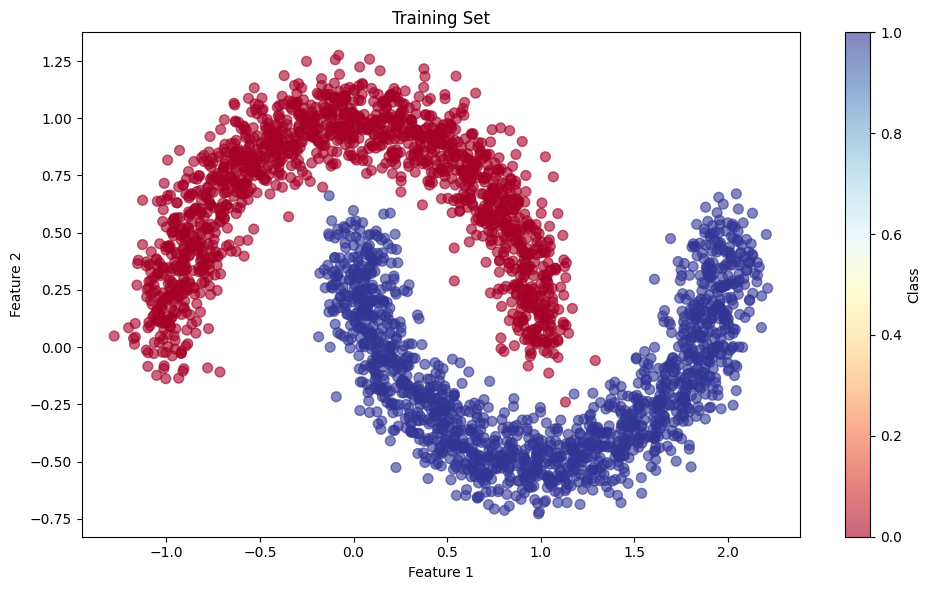

In [3]:
# Generate two moons dataset
X_train, y_train, X_val, y_val, X_test, y_test = generate_two_moons(
    n_samples=config.data.n_samples,
    noise=config.data.noise,
    random_state=config.data.random_state,
    train_ratio=config.data.train_ratio,
    val_ratio=config.data.val_ratio,
    test_ratio=config.data.test_ratio
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature dimension: {X_train.shape[1]}")

# Visualize the dataset
fig, ax = plt.subplots(figsize=(10, 6))
plot_two_moons(X_train, y_train, title="Training Set", ax=ax)
plt.tight_layout()
plt.show()


Model architecture:
TwoMoonsMLP(
  (activation): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

Training model...
Epoch [10/100] Train Loss: 0.0061, Train Acc: 99.90%, Val Loss: 0.0071, Val Acc: 99.80%
Epoch [20/100] Train Loss: 0.0027, Train Acc: 99.93%, Val Loss: 0.0060, Val Acc: 99.80%
Epoch [30/100] Train Loss: 0.0020, Train Acc: 99.93%, Val Loss: 0.0049, Val Acc: 99.80%
Epoch [40/100] Train Loss: 0.0020, Train Acc: 99.93%, Val Loss: 0.0046, Val Acc: 99.80%
Early stopping at epoch 42


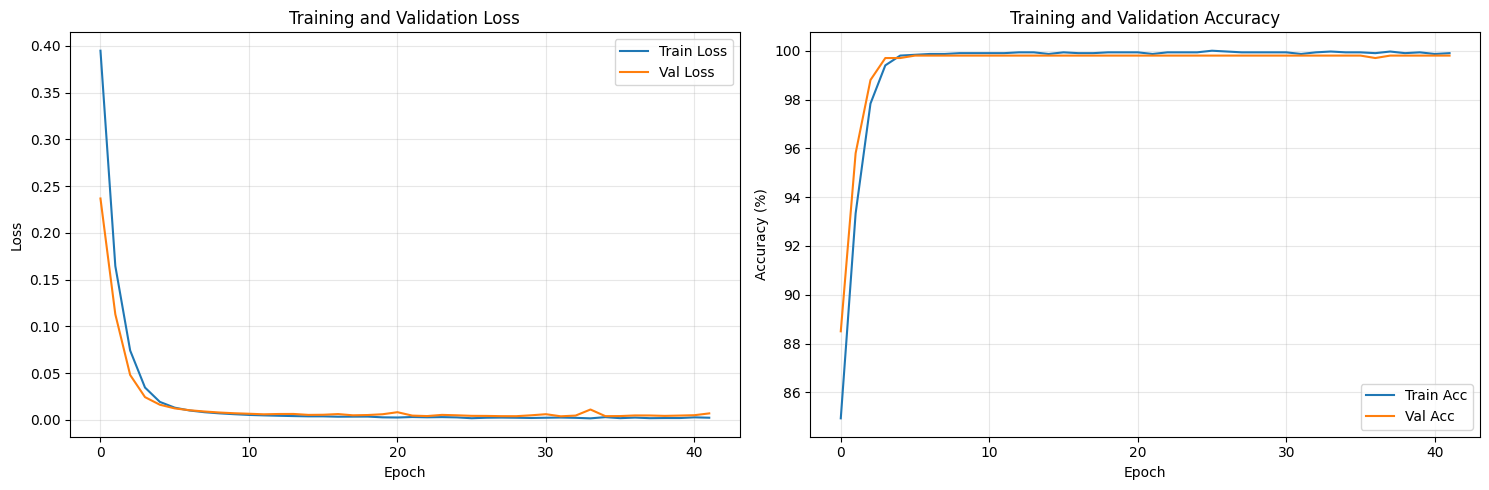

In [4]:
# Train model
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test,
    batch_size=config.model.batch_size
)

# Initialize model
model = TwoMoonsMLP(
    input_dim=config.model.input_dim,
    hidden_dims=config.model.hidden_dims,
    output_dim=config.model.output_dim,
    activation='relu'
)

print(f"Model architecture:")
print(model)

# Train model
print("\nTraining model...")
history = train_model(
    model, train_loader, val_loader, config.model,
    device=config.device, verbose=True
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc')
axes[1].plot(history['val_acc'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Test Loss: 0.0046
Test Accuracy: 99.80%


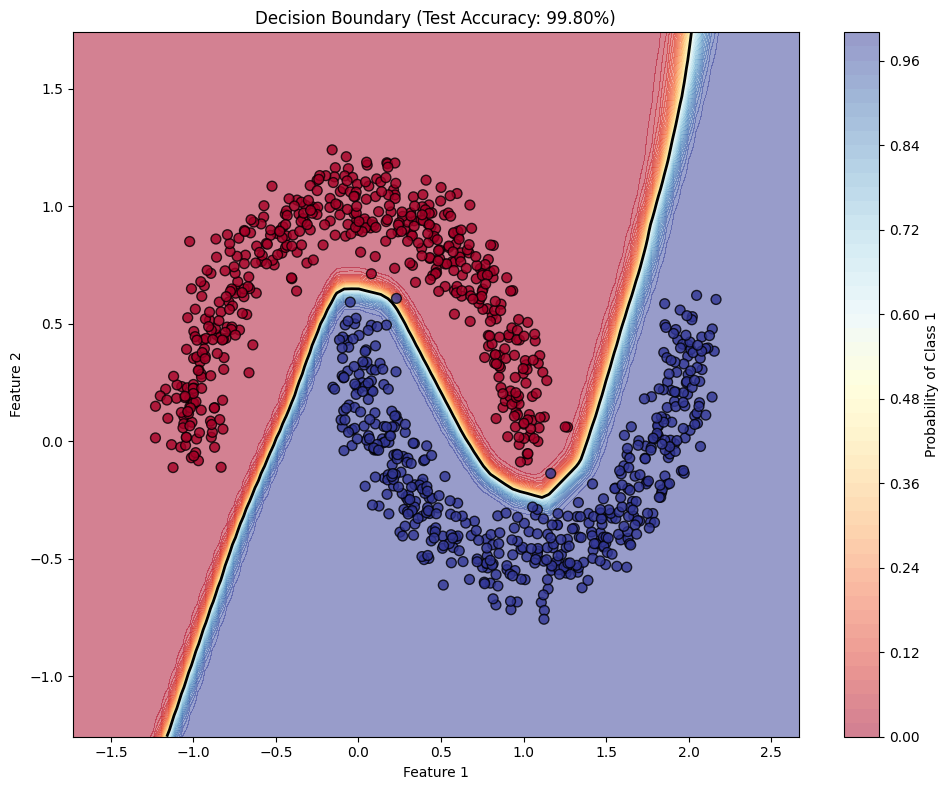

In [5]:
# Evaluate on test set
test_loss, test_acc = evaluate_model(model, test_loader, device=config.device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Visualize decision boundary
fig, ax = plt.subplots(figsize=(10, 8))
plot_decision_boundary(
    model, X_test, y_test,
    title=f"Decision Boundary (Test Accuracy: {test_acc:.2f}%)",
    device=config.device,
    ax=ax
)
plt.tight_layout()
plt.show()


## 5. Generate Adversarial Examples


Generating FGSM adversarial examples...
Attack success rate on validation set: 1.30%
Attack success rate on test set: 1.50%
Successful attacks in val: 13/1000
Successful attacks in test: 15/1000


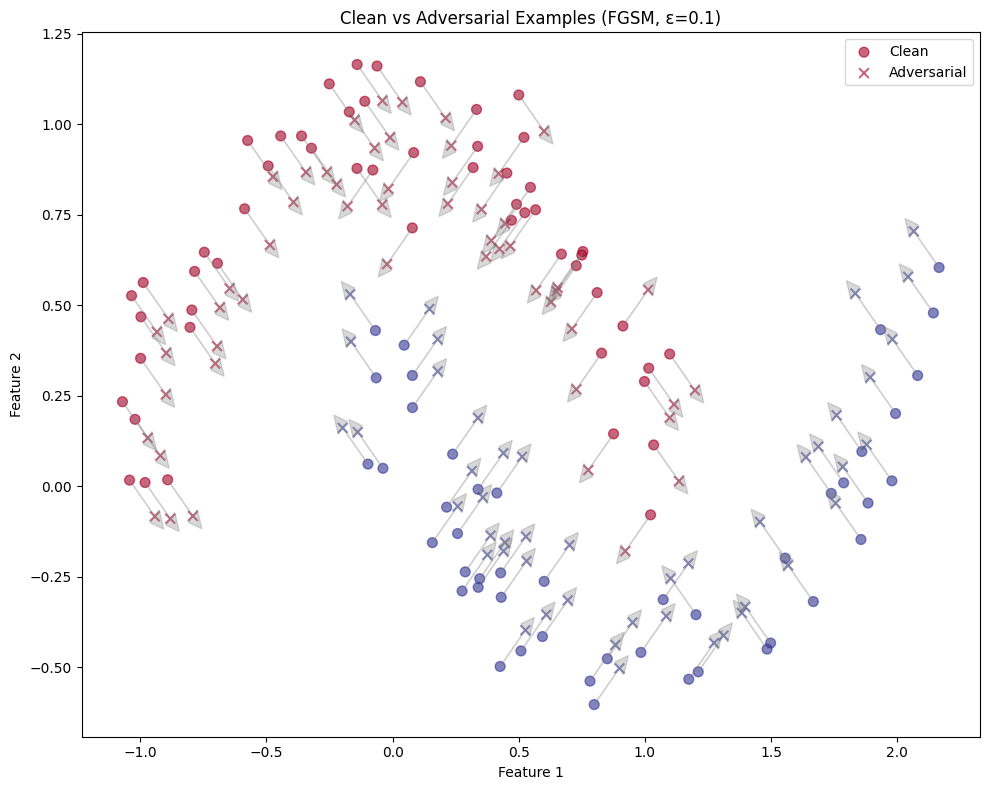

In [6]:
# Generate adversarial examples on validation set
print(f"Generating {config.attack.attack_type.upper()} adversarial examples...")
X_adv_val = generate_adversarial_examples(
    model, X_val, y_val, config.attack,
    device=config.device
)

# Generate adversarial examples on test set
X_adv_test = generate_adversarial_examples(
    model, X_test, y_test, config.attack,
    device=config.device
)

# Compute attack success rate
val_success_rate = compute_attack_success_rate(
    model, X_val, X_adv_val, y_val, device=config.device
)
test_success_rate = compute_attack_success_rate(
    model, X_test, X_adv_test, y_test, device=config.device
)

print(f"Attack success rate on validation set: {val_success_rate:.2f}%")
print(f"Attack success rate on test set: {test_success_rate:.2f}%")

# For evaluation at small eps, it is often more meaningful to evaluate detection
# on *successful* attacks only (points that actually flip the model prediction).
EVAL_ONLY_SUCCESSFUL_ATTACKS = True

pred_val_clean = get_model_predictions(model, X_val, device=config.device)
pred_val_adv = get_model_predictions(model, X_adv_val, device=config.device)
val_success_mask = (pred_val_clean == y_val) & (pred_val_adv != y_val)

pred_test_clean = get_model_predictions(model, X_test, device=config.device)
pred_test_adv = get_model_predictions(model, X_adv_test, device=config.device)
test_success_mask = (pred_test_clean == y_test) & (pred_test_adv != y_test)

print(f"Successful attacks in val: {val_success_mask.sum()}/{len(val_success_mask)}")
print(f"Successful attacks in test: {test_success_mask.sum()}/{len(test_success_mask)}")

# Visualize adversarial examples
fig, ax = plt.subplots(figsize=(10, 8))
plot_adversarial_examples(
    X_test[:100], X_adv_test[:100], y_test[:100],
    title=f"Clean vs Adversarial Examples ({config.attack.attack_type.upper()}, ε={config.attack.epsilon})",
    n_samples=100,
    ax=ax
)
plt.tight_layout()
plt.show()


## 6. Build Graph on Training Data


In [7]:
# Get training representations (input space or feature space)
if config.graph.space == 'feature':
    Z_train = extract_features_batch(
        model, X_train, layer='penultimate', device=config.device
    )
else:
    Z_train = X_train

print(f"Training representations shape: {Z_train.shape}")
print(f"Space: {config.graph.space}")

# Build k-NN graph
print(f"\nBuilding k-NN graph with k={config.graph.k}...")
W_train, D_train, distances_train = build_knn_graph(
    Z_train, k=config.graph.k, sigma=config.graph.sigma
)

print(f"Weight matrix shape: {W_train.shape}")
print(f"Average degree: {W_train.sum(axis=1).mean():.2f}")

# Get model outputs for training data (probabilities)
logits_train = get_model_logits(model, X_train, device=config.device)
probs_train = torch.softmax(torch.FloatTensor(logits_train), dim=1).numpy()
f_train = probs_train[:, 1]  # Probability of class 1

print(f"Training model outputs shape: {f_train.shape}")


Training representations shape: (3000, 32)
Space: feature

Building k-NN graph with k=10...
Weight matrix shape: (3000, 3000)
Average degree: 4.93
Training model outputs shape: (3000,)


## 7. Compute Graph-Based Scores


In [8]:
# Compute scores for clean validation set
print("Computing scores for clean validation set...")
scores_val_clean = compute_graph_scores(
    X_val, model, Z_train, f_train, config.graph, device=config.device
)

# Compute scores for adversarial validation set
print("Computing scores for adversarial validation set...")
scores_val_adv = compute_graph_scores(
    X_adv_val, model, Z_train, f_train, config.graph, device=config.device
)

# Compute scores for clean test set
print("Computing scores for clean test set...")
scores_test_clean = compute_graph_scores(
    X_test, model, Z_train, f_train, config.graph, device=config.device
)

# Compute scores for adversarial test set
print("Computing scores for adversarial test set...")
scores_test_adv = compute_graph_scores(
    X_adv_test, model, Z_train, f_train, config.graph, device=config.device
)

print(f"\nScore types computed: {list(scores_val_clean.keys())}")
if config.detector.score_type in scores_val_clean:
    print(f"Score shape: {scores_val_clean[config.detector.score_type].shape}")
else:
    raise KeyError(
        f"Requested score_type={config.detector.score_type!r} not computed. "
        f"Available score keys: {list(scores_val_clean.keys())}. "
        "If you recently updated src/, restart the notebook kernel to reload modules."
    )


Computing scores for clean validation set...


Computing scores for adversarial validation set...
Computing scores for clean test set...
Computing scores for adversarial test set...

Score types computed: ['degree', 'laplacian', 'tangent_residual', 'tangent_residual_z', 'knn_radius']
Score shape: (1000,)


## 8. Visualize Score Distributions


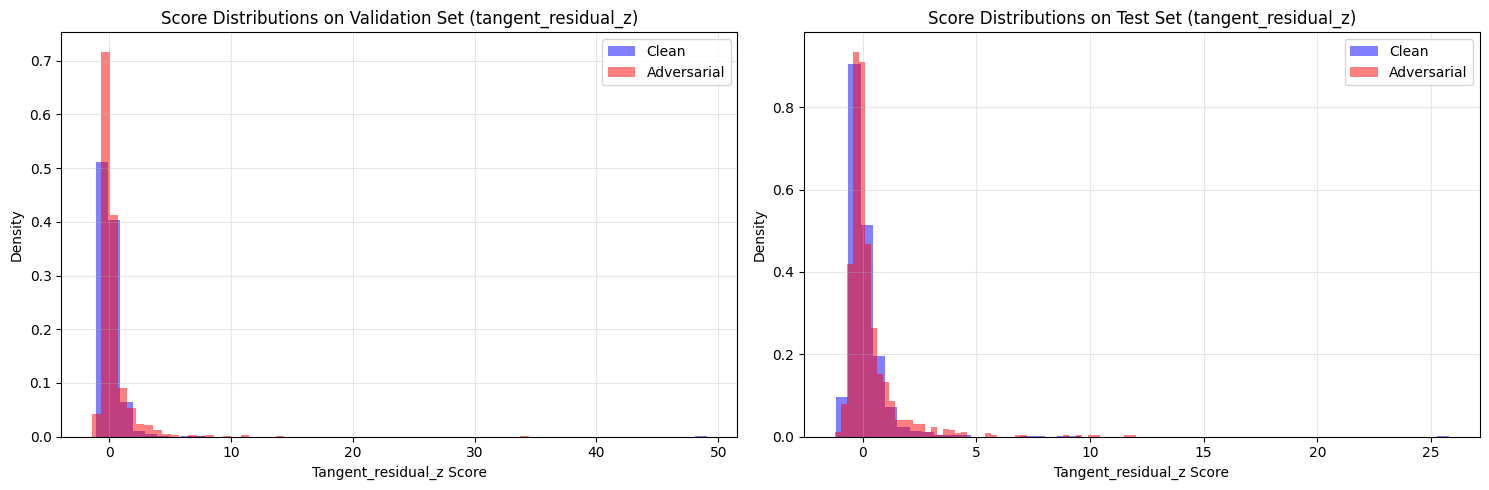

Clean scores - Mean: 0.1119, Std: 1.6891
Adversarial scores - Mean: 0.3057, Std: 1.6537


In [9]:
# Plot score distributions
score_type = config.detector.score_type

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Validation set
plot_score_distributions(
    scores_val_clean[score_type],
    scores_val_adv[score_type],
    score_name=f"{score_type.capitalize()} Score",
    title=f"Score Distributions on Validation Set ({score_type})",
    ax=axes[0]
)

# Test set
plot_score_distributions(
    scores_test_clean[score_type],
    scores_test_adv[score_type],
    score_name=f"{score_type.capitalize()} Score",
    title=f"Score Distributions on Test Set ({score_type})",
    ax=axes[1]
)

plt.tight_layout()
plt.show()

print(f"Clean scores - Mean: {scores_val_clean[score_type].mean():.4f}, Std: {scores_val_clean[score_type].std():.4f}")
print(f"Adversarial scores - Mean: {scores_val_adv[score_type].mean():.4f}, Std: {scores_val_adv[score_type].std():.4f}")


## 9. Train and Evaluate Graph-Based Detector


Training graph-based detector...
Detector trained successfully!
ROC dataset size: n=1015 (clean=1000, adv=15)

Detector Performance (raw scores):
  ROC AUC: 0.4114
  PR AUC: 0.0315
  FPR @ 95% TPR: 0.9930

Detector Performance (trained detector @ 0.5 prob threshold):
  Accuracy: 0.9300
  Precision: 0.0484
  Recall: 0.2000
  F1: 0.0779


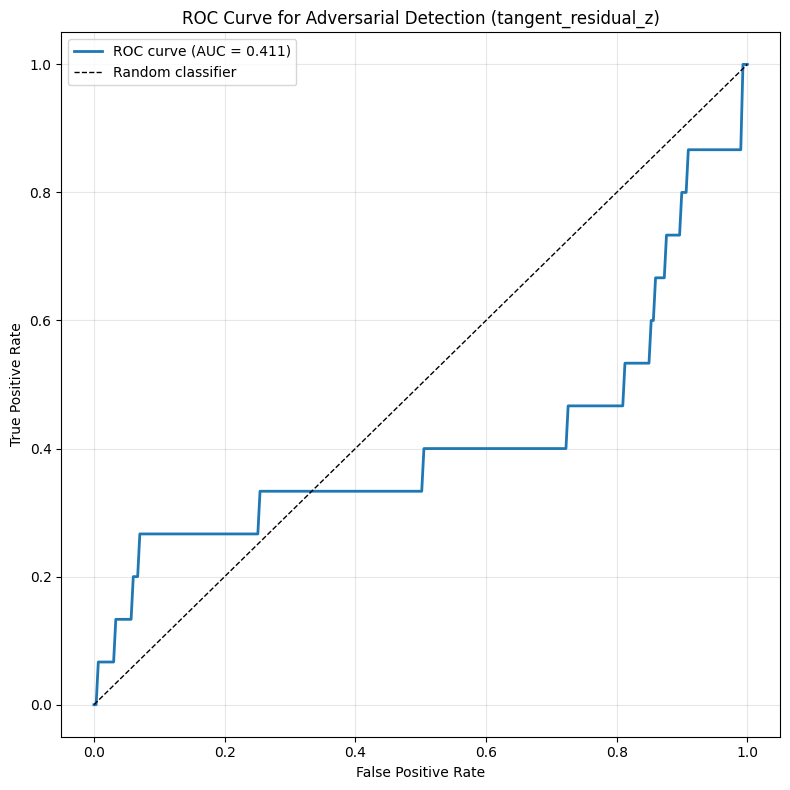

In [10]:
# Prepare validation scores and labels for detector training
# Optionally restrict adversarial set to *successful* attacks (especially important at small eps)
if 'EVAL_ONLY_SUCCESSFUL_ATTACKS' in globals() and EVAL_ONLY_SUCCESSFUL_ATTACKS:
    adv_val_mask = val_success_mask
else:
    adv_val_mask = np.ones(len(X_adv_val), dtype=bool)

scores_val_all = {}
for key in scores_val_clean.keys():
    scores_val_all[key] = np.concatenate([
        scores_val_clean[key],
        scores_val_adv[key][adv_val_mask]
    ])

labels_val = np.concatenate([
    np.zeros(len(scores_val_clean[score_type])),           # 0 = clean
    np.ones(int(adv_val_mask.sum()))                       # 1 = adversarial
])

# Train detector on validation set
print("Training graph-based detector...")
detector = train_graph_detector(
    scores_val_all, labels_val, config.detector
)
print("Detector trained successfully!")

# Evaluate on test set
if 'EVAL_ONLY_SUCCESSFUL_ATTACKS' in globals() and EVAL_ONLY_SUCCESSFUL_ATTACKS:
    adv_test_mask = test_success_mask
else:
    adv_test_mask = np.ones(len(X_adv_test), dtype=bool)

scores_test_all = {}
for key in scores_test_clean.keys():
    scores_test_all[key] = np.concatenate([
        scores_test_clean[key],
        scores_test_adv[key][adv_test_mask]
    ])

labels_test = np.concatenate([
    np.zeros(len(scores_test_clean[score_type])),           # 0 = clean
    np.ones(int(adv_test_mask.sum()))                       # 1 = adversarial
])

print(f"ROC dataset size: n={len(labels_test)} (clean={len(scores_test_clean[score_type])}, adv={int(adv_test_mask.sum())})")

# Get detector predictions (thresholded) + probability proxy
predictions_test, probs_test = predict_graph_detector(detector, scores_test_all)

# 1) Raw-score ranking performance (AUC) using the selected score_type
raw_test_scores = scores_test_all[score_type]
raw_metrics = evaluate_detector(labels_test, raw_test_scores)

# 2) The trained detector as a binary classifier
#    (for ScoreBasedDetector, probs_test is a monotone transform around its learned threshold)
trained_metrics = evaluate_detector(labels_test, probs_test, threshold=0.5)

print(f"\nDetector Performance (raw scores):")
print(f"  ROC AUC: {raw_metrics['roc_auc']:.4f}")
print(f"  PR AUC: {raw_metrics['pr_auc']:.4f}")
print(f"  FPR @ 95% TPR: {raw_metrics['fpr_at_tpr95']:.4f}")

print(f"\nDetector Performance (trained detector @ 0.5 prob threshold):")
print(f"  Accuracy: {trained_metrics['accuracy']:.4f}")
print(f"  Precision: {trained_metrics['precision']:.4f}")
print(f"  Recall: {trained_metrics['recall']:.4f}")
print(f"  F1: {trained_metrics['f1']:.4f}")

# Plot ROC curve (raw score AUC)
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(
    raw_metrics['fpr'],
    raw_metrics['tpr'],
    raw_metrics['roc_auc'],
    title=f"ROC Curve for Adversarial Detection ({score_type})",
    ax=ax,
    interpolate=True,
    n_points=300
)
plt.tight_layout()
plt.show()


## 10. Visualize Scores on Test Set


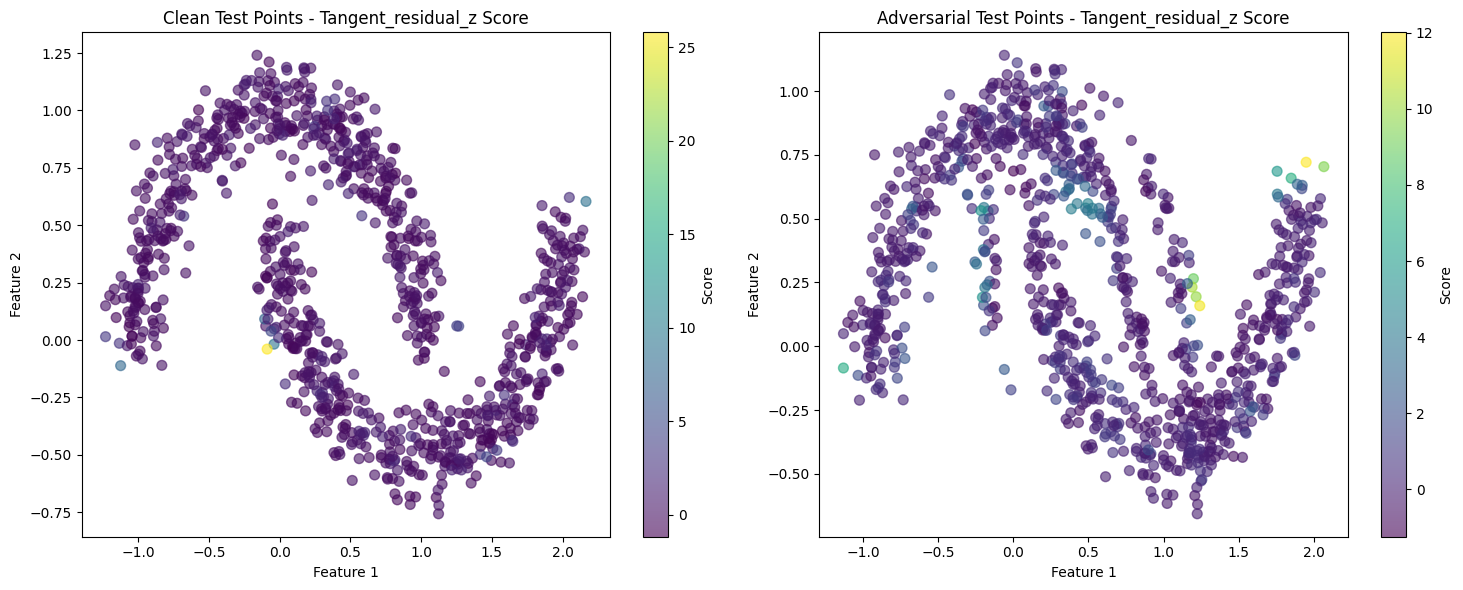

In [11]:
# Visualize scores on test set
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Clean test points colored by score
plot_score_scatter(
    X_test, scores_test_clean[score_type],
    title=f"Clean Test Points - {score_type.capitalize()} Score",
    cmap='viridis',
    ax=axes[0]
)

# Adversarial test points colored by score
plot_score_scatter(
    X_adv_test, scores_test_adv[score_type],
    title=f"Adversarial Test Points - {score_type.capitalize()} Score",
    cmap='viridis',
    ax=axes[1]
)

plt.tight_layout()
plt.show()


## 11. Calibrate Scores to Error Probabilities


Calibrating scores to error probabilities...
Expected Calibration Error (ECE): 0.0000
Max Calibration Error (MCE): 0.0000


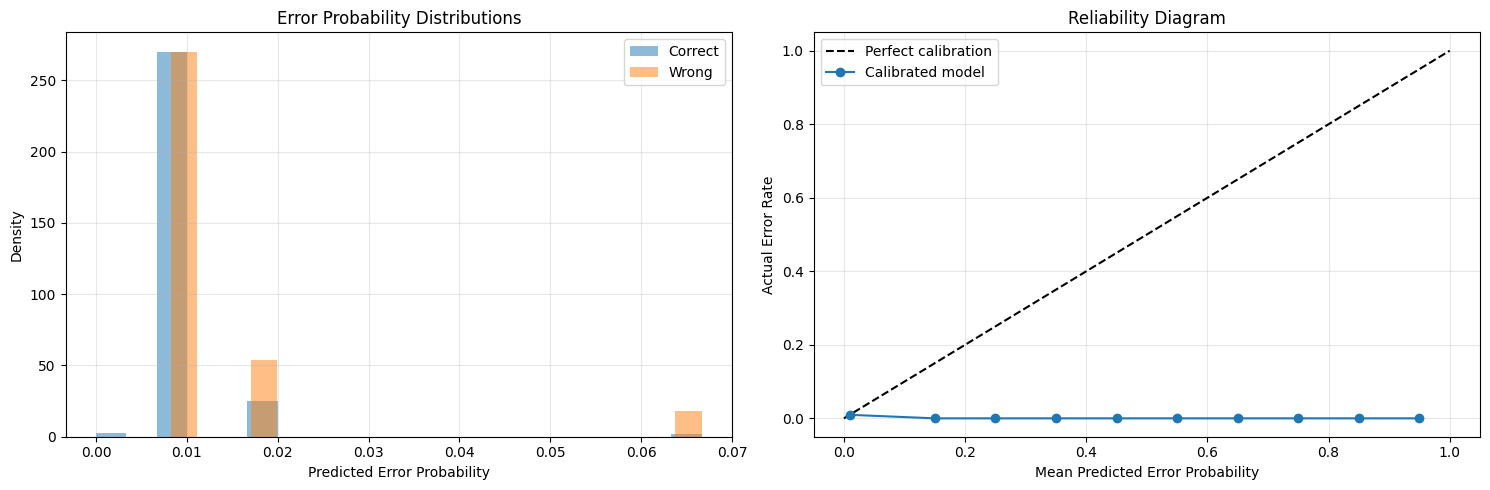

In [12]:
# Determine which predictions are wrong
pred_test_clean = get_model_predictions(model, X_test, device=config.device)
pred_test_adv = get_model_predictions(model, X_adv_test, device=config.device)

is_wrong_clean = (pred_test_clean != y_test).astype(int)
is_wrong_adv = (pred_test_adv != y_test).astype(int)

# Combine for calibration
all_test_scores = np.concatenate([scores_test_clean[score_type], scores_test_adv[score_type]])
all_is_wrong = np.concatenate([is_wrong_clean, is_wrong_adv])

# Calibrate scores to error probabilities
print("Calibrating scores to error probabilities...")
calibration_model = calibrate_error_probability(
    all_test_scores, all_is_wrong,
    method=config.detector.calibration_method
)

# Predict error probabilities
error_probs = predict_error_probability(
    calibration_model, all_test_scores,
    method=config.detector.calibration_method
)

# Compute calibration metrics
cal_metrics = compute_calibration_metrics(error_probs, all_is_wrong)
print(f"Expected Calibration Error (ECE): {cal_metrics['ece']:.4f}")
print(f"Max Calibration Error (MCE): {cal_metrics['mce']:.4f}")

# Plot calibration
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of error probabilities
axes[0].hist(error_probs[all_is_wrong == 0], bins=20, alpha=0.5, label='Correct', density=True)
axes[0].hist(error_probs[all_is_wrong == 1], bins=20, alpha=0.5, label='Wrong', density=True)
axes[0].set_xlabel('Predicted Error Probability')
axes[0].set_ylabel('Density')
axes[0].set_title('Error Probability Distributions')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reliability diagram
n_bins = 10
bin_boundaries = np.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = (bin_lowers + bin_uppers) / 2

accuracies = []
confidences = []

for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    in_bin = (error_probs > bin_lower) & (error_probs <= bin_upper)
    if in_bin.sum() > 0:
        accuracy = all_is_wrong[in_bin].mean()
        confidence = error_probs[in_bin].mean()
        accuracies.append(accuracy)
        confidences.append(confidence)
    else:
        accuracies.append(0)
        confidences.append(bin_centers[len(accuracies) - 1])

axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
axes[1].plot(confidences, accuracies, 'o-', label='Calibrated model')
axes[1].set_xlabel('Mean Predicted Error Probability')
axes[1].set_ylabel('Actual Error Rate')
axes[1].set_title('Reliability Diagram')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 12. Error Probability Examples


In [13]:
# Show examples of error probability predictions
print("Example predictions with error probabilities:\n")
print("=" * 80)

# Select a few examples from each category
n_examples = 5

# Clean examples with high error prob
clean_indices = np.where(all_is_wrong == 0)[0]
high_error_prob_clean = clean_indices[np.argsort(error_probs[clean_indices])[-n_examples:][::-1]]

# Wrong predictions
wrong_indices = np.where(all_is_wrong == 1)[0]
if len(wrong_indices) > 0:
    high_error_prob_wrong = wrong_indices[np.argsort(error_probs[wrong_indices])[-n_examples:][::-1]]
else:
    high_error_prob_wrong = []

print(f"\nTop {n_examples} clean examples with highest predicted error probability:")
for idx in high_error_prob_clean[:n_examples]:
    is_adv = "Adversarial" if idx >= len(X_test) else "Clean"
    point_idx = idx if idx < len(X_test) else idx - len(X_test)
    actual_label = y_test[point_idx]
    pred_label = pred_test_adv[point_idx] if idx >= len(X_test) else pred_test_clean[point_idx]
    score = all_test_scores[idx]
    err_prob = error_probs[idx]
    print(f"  {is_adv} point {point_idx}: True={actual_label}, Pred={pred_label}, "
          f"Score={score:.4f}, P(error)={err_prob:.4f}")

if len(high_error_prob_wrong) > 0:
    print(f"\nTop {n_examples} wrong predictions with highest error probability:")
    for idx in high_error_prob_wrong[:n_examples]:
        is_adv = "Adversarial" if idx >= len(X_test) else "Clean"
        point_idx = idx if idx < len(X_test) else idx - len(X_test)
        actual_label = y_test[point_idx]
        pred_label = pred_test_adv[point_idx] if idx >= len(X_test) else pred_test_clean[point_idx]
        score = all_test_scores[idx]
        err_prob = error_probs[idx]
        print(f"  {is_adv} point {point_idx}: True={actual_label}, Pred={pred_label}, "
              f"Score={score:.4f}, P(error)={err_prob:.4f}")

print("\n" + "=" * 80)


Example predictions with error probabilities:


Top 5 clean examples with highest predicted error probability:
  Adversarial point 78: True=1, Pred=1, Score=9.4489, P(error)=0.0667
  Adversarial point 527: True=0, Pred=0, Score=10.2818, P(error)=0.0667
  Clean point 333: True=1, Pred=1, Score=9.1235, P(error)=0.0667
  Clean point 781: True=0, Pred=0, Score=7.7443, P(error)=0.0667
  Clean point 78: True=1, Pred=1, Score=8.7929, P(error)=0.0667

Top 5 wrong predictions with highest error probability:
  Adversarial point 710: True=1, Pred=0, Score=5.6282, P(error)=0.0667
  Adversarial point 506: True=1, Pred=0, Score=1.0728, P(error)=0.0178
  Adversarial point 188: True=1, Pred=0, Score=1.6086, P(error)=0.0178
  Adversarial point 877: True=1, Pred=0, Score=1.2245, P(error)=0.0178
  Clean point 747: True=1, Pred=0, Score=0.4305, P(error)=0.0090

